In [247]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Read CSV File

In [248]:
df = pd.read_csv('cleaned_data.csv')
result_df = pd.DataFrame()

# DataFrame to np.array

In [249]:
targetValue = 'Overall Survival Status'

In [250]:
features = df.drop([targetValue, 'Patient ID'], axis=1).values
target = df[targetValue].values

# Train,Test,Split

In [251]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Linear Regression

In [252]:
LR_model = LinearRegression()
LR_model.fit(x_train, y_train)

LinearRegression()

In [253]:
y_pred = LR_model.predict(x_test).astype('int64')
result_df = result_df.assign(test=y_test, LR_pred=y_pred)

In [254]:
matching_rows = (result_df['test'] == result_df['LR_pred']).sum()
print(f"تعداد ردیف‌ها: {result_df.shape[0]}")
print(f"تعداد ردیف‌هایی که مقادیر برابر دارند: {matching_rows}")


تعداد ردیف‌ها: 502
تعداد ردیف‌هایی که مقادیر برابر دارند: 313


# Decision Tree

In [255]:
DT_model = tree.DecisionTreeRegressor(min_samples_leaf=3, random_state=42)
DT_model.fit(x_train, y_train)

DecisionTreeRegressor(min_samples_leaf=3, random_state=42)

In [256]:
y_pred = DT_model.predict(x_test).astype('int64')
result_df = result_df.assign(DT_pred=y_pred)

In [257]:
matching_rows = (result_df['test'] == result_df['DT_pred']).sum()
print(f"تعداد ردیف‌هایی که مقادیر برابر دارند: {matching_rows}")

تعداد ردیف‌هایی که مقادیر برابر دارند: 502


# Random Forest

In [258]:
RF_model = RandomForestRegressor(max_depth=3, random_state=42)
RF_model.fit(x_train, y_train)

RandomForestRegressor(max_depth=3, random_state=42)

In [259]:
y_pred = RF_model.predict(x_test).astype('int64')
result_df = result_df.assign(RF_pred=y_pred)

In [260]:
matching_rows = (result_df['test'] == result_df['RF_pred']).sum()
print(f"تعداد ردیف‌هایی که مقادیر برابر دارند: {matching_rows}")

تعداد ردیف‌هایی که مقادیر برابر دارند: 501


In [261]:
print(result_df.shape[0])
result_df.sample(10)

502


,test,LR_pred,DT_pred,RF_pred
423,0,0,0,0
189,0,0,0,0
464,0,0,0,0
84,1,0,1,1
282,2,1,2,2
426,1,1,1,1
218,1,1,1,1
260,2,1,2,2
221,1,1,1,1
89,0,0,0,0


## Confusion Matrix

In [262]:
def my_confusion_matrix(y_test, y_pred, num_classes):
    conf_matrix = np.zeros((num_classes, num_classes), dtype=int)
    for i in range(num_classes):
        for j in range(num_classes):
            conf_matrix[i, j] = np.sum((y_test == i) & (y_pred == j))

    return conf_matrix

def metrics(conf_matrix):
    num_classes = len(conf_matrix)
    results = {}

    for i in range(num_classes):
        true_positive = conf_matrix[i, i]
        true_negative = np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1))
        false_positive = np.sum(conf_matrix[:, i]) - true_positive
        false_negative = np.sum(conf_matrix[i, :]) - true_positive

        total = true_positive + true_negative + false_positive + false_negative
        positives = true_positive + false_negative
        negatives = true_negative + false_positive

        sensitivity = true_positive / positives if positives > 0 else 0  # Recall
        specificity = true_negative / negatives if negatives > 0 else 0
        precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0

        results[f'Class {i}'] = {
            'TP': true_positive,
            'TN': true_negative,
            'FP': false_positive,
            'FN': false_negative,
            'Total': total,
            'Positives': positives,
            'Negatives': negatives,
            'Sensitivity(Recall)': sensitivity,
            'Specificity': specificity,
            'Precision': precision
        }

    return results

In [263]:
number_of_classes = len(result_df['test'].unique())
conf_matrix = my_confusion_matrix(result_df['test'], result_df['LR_pred'], number_of_classes)
print(conf_matrix)


[[120   0   0]
 [ 68  92   0]
 [  0 121 101]]


In [264]:
evaluation_results = metrics(conf_matrix)
df_results = pd.DataFrame.from_dict(evaluation_results, orient='index')
df_results.head()

,TP,TN,FP,FN,Total,Positives,Negatives,Sensitivity(Recall),Specificity,Precision
Class 0,120,314,68,0,502,120,382,1.000000,0.821990,0.638298
Class 1,92,221,121,68,502,160,342,0.575000,0.646199,0.431925
Class 2,101,280,0,121,502,222,280,0.454955,1.000000,1.000000


In [265]:
def roc_curve_scratch(y_test, y_predict):
    thresholds = np.linspace(np.min(y_predict), np.max(y_predict), 4)
    roc_fp_rate, roc_rp_rate, auc_value = [], [], 0.0

    for item in thresholds:
        y_pred = (y_predict >= item).astype(int)
        evaluation = metrics(confusion_matrix(y_test, y_pred))

        tpr_value = evaluation['Class 1']['Sensitivity(Recall)']
        fpr_value = evaluation['Class 0']['FP'] / evaluation['Class 0']['Negatives']
        print(tpr_value,fpr_value)
        roc_rp_rate.append(tpr_value)
        roc_fp_rate.append(fpr_value)

    for i in range(1, len(thresholds)):
        y_pred_high = (y_predict >= thresholds[i]).astype(int)
        y_pred_low = (y_predict >= thresholds[i - 1]).astype(int)

        evaluation_high = metrics(confusion_matrix(y_test, y_pred_high))
        evaluation_low = metrics(confusion_matrix(y_test, y_pred_low))

        tpr_high = evaluation_high['Class 1']['Sensitivity(Recall)']
        fpr_high = evaluation_high['Class 0']['FP'] / evaluation_high['Class 0']['Negatives']

        tpr_low = evaluation_low['Class 1']['Sensitivity(Recall)']
        fpr_low = evaluation_low['Class 0']['FP'] / evaluation_low['Class 0']['Negatives']

        auc_value += 0.5 * (tpr_high + tpr_low) * (fpr_low - fpr_high)

    roc_fp_rate[0] = 1
    roc_fp_rate[-1] = 0
    roc_rp_rate[0] = 1
    roc_rp_rate[-1] = 0

    return roc_fp_rate, roc_rp_rate, thresholds, auc_value


In [266]:
roc_fpr, roc_tpr, thresholds, auc_value = roc_curve_scratch(result_df['test'], result_df['LR_pred'])
print(roc_fpr,'\n', roc_tpr,'\n', thresholds,'\n', auc_value)

1.0 0.0
0.575 0.17801047120418848
0.0 0.7356020942408377
0.0 0.7356020942408377
[1, 0.17801047120418848, 0.7356020942408377, 0] 
 [1, 0.575, 0.0, 0] 
 [0.         0.66666667 1.33333333 2.        ] 
 -0.30049083769633506


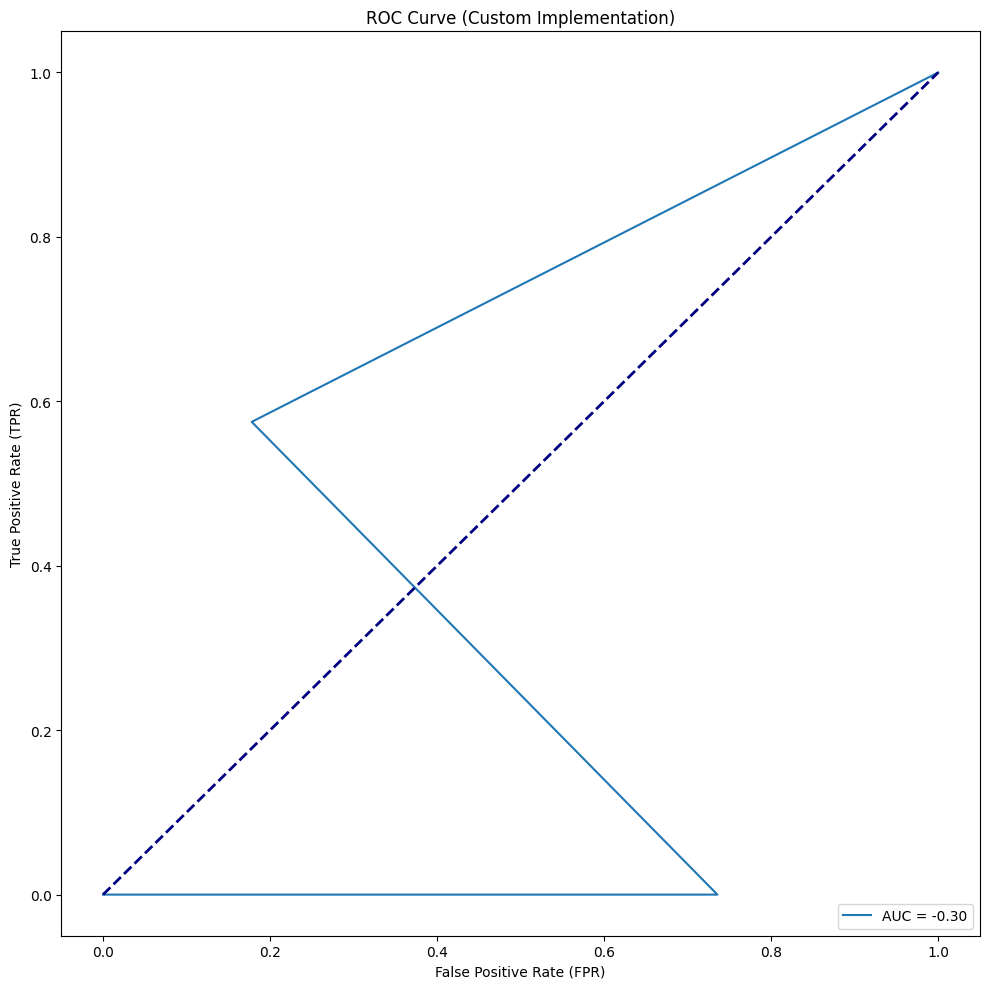

In [267]:
def roc_curve_graph(roc_fpr, roc_tpr, auc_value, save_path='roc_curves.jpg'):
    plt.figure(figsize=(10, 10))
    plt.plot(roc_fpr, roc_tpr, label=f'AUC = {auc_value:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.title('ROC Curve (Custom Implementation)')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig(save_path, format='jpg', bbox_inches='tight', pad_inches=0)
    plt.show()
roc_curve_graph(roc_fpr, roc_tpr, auc_value)
